In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('../dataset/raw_dataset.csv')
df.describe()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987.000000
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,0.921218
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,0.269400
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,1.000000
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,1.000000
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000


In [3]:
df['created_at'] = pd.to_datetime(df['created_at'])
print(df['created_at'].min())
print(df['created_at'].max())

2017-09-05 00:01:02+00:00
2017-10-04 23:58:53+00:00


In [19]:
df[df.to_user_distance==0]

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,year,month,day,dayofweek
16847,14362872,900012381,0.0,0.0,5000,2017-09-07 19:48:10+00:00,0,2017,9,7,3


In [20]:
df[df.to_user_elevation==0]

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,year,month,day,dayofweek
16847,14362872,900012381,0.000000,0.0,5000,2017-09-07 19:48:10+00:00,0,2017,9,7,3
18895,15480647,30000063,0.015630,0.0,6200,2017-09-27 13:30:58+00:00,1,2017,9,27,2
23526,15377385,900012790,0.008066,0.0,3200,2017-09-25 16:52:54+00:00,1,2017,9,25,0
26211,15522625,900007604,0.016700,0.0,4200,2017-09-28 13:05:04+00:00,1,2017,9,28,3
26810,15568997,900010565,0.049237,0.0,5200,2017-09-29 11:38:57+00:00,1,2017,9,29,4
29610,15640451,900006688,0.028470,0.0,5500,2017-09-30 14:06:06+00:00,0,2017,9,30,5
29881,14557537,900009486,0.021633,0.0,4500,2017-09-10 18:23:11+00:00,1,2017,9,10,6
29924,14561051,900009486,0.027300,0.0,4500,2017-09-10 18:56:11+00:00,1,2017,9,10,6
31541,15145180,900012789,0.022779,0.0,3700,2017-09-21 19:46:57+00:00,1,2017,9,21,3
38910,15323620,900010565,0.049241,0.0,4500,2017-09-24 16:20:58+00:00,1,2017,9,24,6


In [21]:
df[df.total_earning==0]

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,year,month,day,dayofweek
102163,14323700,900010714,1.388912,48.826538,0,2017-09-07 12:02:05+00:00,1,2017,9,7,3


In [ ]:
df.astype(bool).sum(axis=0)


In [ ]:
df.isnull().sum()


In [4]:
df[df.store_id==900015404].head(10)
df.sort_values("to_user_elevation", ascending=True).head(20)

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
117263,15316990,900014587,2.842699,-598.296875,12900,2017-09-24 14:48:00+00:00,1
122107,15631909,900014587,2.842699,-598.296875,19800,2017-09-30 12:22:05+00:00,1
135312,15704105,900014587,2.779747,-593.872314,10850,2017-10-01 12:34:06+00:00,1
5470,14866765,900014587,2.888839,-580.946167,7600,2017-09-16 18:11:50+00:00,0
95376,15702861,900014587,2.858009,-575.976318,10800,2017-10-01 12:25:04+00:00,1
7161,15513087,900014587,2.731024,-572.014648,11900,2017-09-28 10:08:53+00:00,1
2320,14832740,900014587,2.726192,-569.226196,9500,2017-09-16 11:02:45+00:00,1
76103,14719709,900014587,2.726192,-569.226196,8500,2017-09-14 09:58:04+00:00,1
35482,15296575,900014587,2.726192,-569.226196,16650,2017-09-24 10:40:51+00:00,1
113848,15044335,900014587,2.432287,-545.471680,9100,2017-09-19 18:53:53+00:00,1


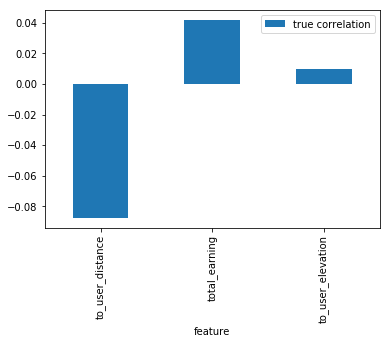

In [5]:
features = ['to_user_distance','to_user_elevation','total_earning','taken']

# Features correlation coefficent to label
fi = pd.DataFrame({'feature': features,
                   'correlation': df[features].corr()['taken'].abs(),
                   'true correlation': df[features].corr()['taken']
                  }).sort_values('correlation', ascending = False)

fi[fi.feature!='taken'].head(10).plot.bar(x='feature', y ='true correlation')

In [6]:
df['year'] = pd.to_datetime(df['created_at']).apply(lambda x: '{year}'.format(year=x.year)).astype(int)
df['month'] = pd.to_datetime(df['created_at']).apply(lambda x: '{month}'.format(month=x.month)).astype(int)
df['day'] = pd.to_datetime(df['created_at']).apply(lambda x: '{day}'.format(day=x.day)).astype(int)
df['dayofweek'] = pd.to_datetime(df['created_at']).apply(lambda x: '{dayofweek}'.format(dayofweek=x.dayofweek)).astype(int)


In [7]:
grouped = df[['year','month','day','taken']][df.taken==1].groupby(by=['year','month','day']).count()
grouped.sort_values(by=['year','month','day'], ascending=True )

taken
year month day       
2017 9     5     3404
           6     3576
           7     3747
           8     5488
           9     4922
           10    6451
           11    3221
           12    2998
           13    3576
           14    3647
           15    4582
           16    5671
           17    7083
           18    3275
           19    3553
           20    3472
           21    3682
           22    4947
           23    6057
           24    7517
           25    4100
           26    6484
           27    3170
           28    3835
           29    4343
           30    5608
     10    1     7247
           2     3096
           3     3091
           4     3564

In [23]:
grouped['not_taken'] = df[['year','month','day','taken']][df.taken==0].groupby(by=['year','month','day']).count()
grouped['total'] = grouped.not_taken + grouped.taken
grouped['rate'] = grouped.not_taken/grouped.total
grouped = grouped.reset_index()

In [24]:
grouped['date'] = grouped.year.astype(str) + '-' + grouped.month.astype(str) + '-' + grouped.day.astype(str)
grouped['date'] = pd.to_datetime(grouped.date)

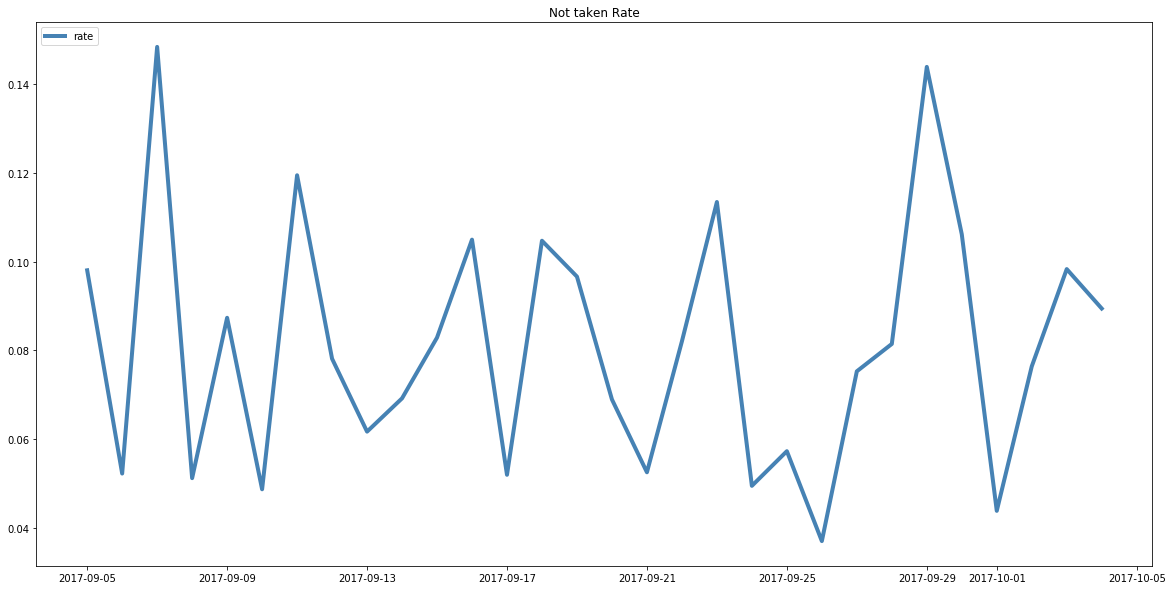

In [25]:
plt.figure(figsize=(20, 10))
plt.title('Not taken Rate')
plt.xticks(size = 10)
plt.plot(grouped.date, grouped.rate, c='steelblue', linewidth=4, zorder=10)
plt.legend(loc='upper left')
plt.show()


In [27]:
grouped_store = df[['store_id','taken']][df.taken==1].groupby(by=['store_id']).count().fillna(0)
grouped_store['not_taken'] = df[['store_id','taken']][df.taken==0].groupby(by=['store_id']).count()
grouped_store['not_taken'] = grouped_store['not_taken'].fillna(0)
grouped_store['total'] = grouped_store.not_taken + grouped_store.taken
grouped_store['rate'] = grouped_store.not_taken/grouped_store.total
grouped_store = grouped_store.reset_index()

grouped_store[grouped_store.total>20].sort_values('rate', ascending=False).head(10)

,store_id,taken,not_taken,total,rate
345,900010618,9,12.0,21.0,0.571429
274,900008544,14,11.0,25.0,0.440000
531,900013366,17,12.0,29.0,0.413793
671,900015231,37,26.0,63.0,0.412698
681,900015309,43,28.0,71.0,0.394366
819,900016790,23,14.0,37.0,0.378378
406,900011560,17,10.0,27.0,0.370370
573,900013938,77,45.0,122.0,0.368852
731,900015782,22,11.0,33.0,0.333333
583,900014066,18,9.0,27.0,0.333333


In [22]:
grouped_store[grouped_store.total>10].sort_values('rate', ascending=False).head(10)

NameError: name 'grouped_store' is not defined

In [184]:
grouped_dayw = df[['dayofweek','taken']][df.taken==1].groupby(by=['dayofweek']).count().fillna(0)
grouped_dayw['not_taken'] = df[['dayofweek','taken']][df.taken==0].groupby(by=['dayofweek']).count()
grouped_dayw['not_taken'] = grouped_dayw['not_taken'].fillna(0)
grouped_dayw['total'] = grouped_dayw.not_taken + grouped_dayw.taken
grouped_dayw['rate'] = grouped_dayw.not_taken/grouped_dayw.total
grouped_dayw = grouped_dayw.reset_index()


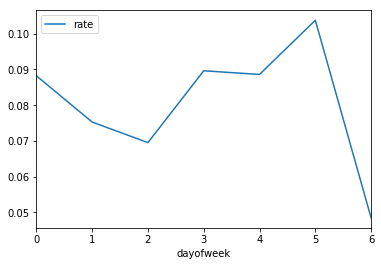

In [187]:
grouped_dayw.plot('dayofweek','rate')


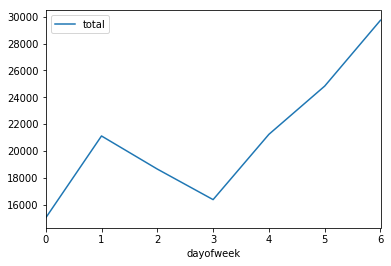

In [188]:
grouped_dayw.plot('dayofweek','total')

In [ ]:
df[df.store_id==30000017].sort_values('created_at')

In [8]:
import sqlite3
conn = sqlite3.connect('raw_dataset.db')
df.to_sql('couriers_rejection',conn, if_exists='append')


In [9]:

query = '''
select 
    c.order_id
    ,round(1.00*sum(case when c2.taken=0 then 1 else 0 end)/count(distinct c2.order_id),4) as "store_not_taken_rate_2d"
        ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<1
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<1
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_1d"
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.5 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.5 
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_12h"
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.125 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.125
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_3h"
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.04 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.04
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_1h"

from 
    couriers_rejection c
    left outer join couriers_rejection c2 on c2.store_id=c.store_id 
        and c2.order_id<>c.order_id 
        and c2.created_at < c.created_at 
        and (JulianDay(c.created_at) - JulianDay(c2.created_at))<2
where 1=1
group by 
     c.order_id
     
'''
df_store_rates = pd.read_sql_query(query, conn).fillna(0)

In [10]:
merged_inner = pd.merge(left=df,right=df_store_rates, left_on='order_id', right_on='order_id')
# merged_inner = pd.merge(left=merged_inner,right=df_general_rates, left_on='order_id', right_on='order_id')


In [ ]:

query = '''
select 
    c.order_id
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.125 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.125
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_3h"
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.04 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.04
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_1h"
    ,round(1.00*
        sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.02 
            and c2.taken=0 
            then 1 else 0 end)
        /sum(case when 
            (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.02
            then 1 else 0 end)
    ,4) as "store_not_taken_rate_30m"


from 
    couriers_rejection c
    left outer join couriers_rejection c2 on
        c2.order_id<>c.order_id 
        and c2.created_at < c.created_at 
        and (JulianDay(c.created_at) - JulianDay(c2.created_at))<0.5
where 1=1
group by 
     c.order_id
     
'''
df_general_rates = pd.read_sql_query(query, conn).fillna(0)

In [11]:
merged_inner['to_user_distance_p95'] = (merged_inner.to_user_distance>merged_inner['to_user_distance'].quantile(q=0.95)).astype(int)
merged_inner['to_user_distance_p90'] = (merged_inner.to_user_distance>merged_inner['to_user_distance'].quantile(q=0.90)).astype(int)
merged_inner['to_user_distance_p75'] = (merged_inner.to_user_distance>merged_inner['to_user_distance'].quantile(q=0.75)).astype(int)
merged_inner['to_user_distance_p25'] = (merged_inner.to_user_distance>merged_inner['to_user_distance'].quantile(q=0.25)).astype(int)

merged_inner['to_user_elevation_p95']= (merged_inner.to_user_distance>merged_inner['to_user_elevation'].quantile(q=0.95)).astype(int)
merged_inner['to_user_elevation_p90']= (merged_inner.to_user_distance>merged_inner['to_user_elevation'].quantile(q=0.90)).astype(int)
merged_inner['to_user_elevation_p75']= (merged_inner.to_user_distance>merged_inner['to_user_elevation'].quantile(q=0.75)).astype(int)
merged_inner['to_user_elevation_p25'] = (merged_inner.to_user_distance>merged_inner['to_user_elevation'].quantile(q=0.25)).astype(int)




In [12]:
risk_group_1 = [5]
risk_group_2 = [0,3,4]
risk_group_3 = [1,2]
risk_group_4 = [6]

merged_inner['day_risk_group_1'] = (merged_inner.dayofweek.isin(risk_group_1)).astype(int)
merged_inner['day_risk_group_2'] = (merged_inner.dayofweek.isin(risk_group_2)).astype(int)
merged_inner['day_risk_group_3'] = (merged_inner.dayofweek.isin(risk_group_3)).astype(int)
merged_inner['day_risk_group_4'] = (merged_inner.dayofweek.isin(risk_group_4)).astype(int)



In [13]:
merged_inner['rate_earning_distance'] = merged_inner.total_earning/merged_inner.to_user_distance
merged_inner['rate_earning_elevation'] = merged_inner.total_earning/merged_inner.to_user_elevation
merged_inner['negative_el_diff'] = (merged_inner.to_user_elevation<0).astype(int)

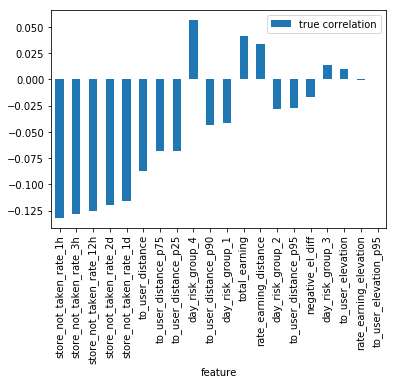

In [15]:
features = ['to_user_distance'
            ,'to_user_distance_p95'
            ,'to_user_distance_p90'
            ,'to_user_distance_p75'
            ,'to_user_distance_p25'
            ,'to_user_elevation'
            ,'to_user_elevation_p95'
            ,'to_user_elevation_p90'
            ,'to_user_elevation_p75'
            ,'to_user_elevation_p25'
            ,'total_earning'
            ,'day_risk_group_1'
            ,'day_risk_group_2'
            ,'day_risk_group_3'
            ,'day_risk_group_4'
            ,'store_not_taken_rate_2d'
            ,'store_not_taken_rate_1d'
            ,'store_not_taken_rate_12h'
            ,'store_not_taken_rate_3h'
            ,'store_not_taken_rate_1h'
            ,'rate_earning_distance'
            ,'rate_earning_elevation'
            ,'negative_el_diff'
            ,'taken'
           ]

# Features correlation coefficent to label
fi = pd.DataFrame({'feature': features,
                   'correlation': merged_inner[features].corr()['taken'].abs(),
                   'true correlation': merged_inner[features].corr()['taken']
                  }).sort_values('correlation', ascending = False)

fi[fi.feature!='taken'].head(20).plot.bar(x='feature', y ='true correlation')

In [18]:
merged_inner[merged_inner.to_user_distance==0]

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,year,month,day,...,to_user_elevation_p90,to_user_elevation_p75,to_user_elevation_p25,day_risk_group_1,day_risk_group_2,day_risk_group_3,day_risk_group_4,rate_earning_distance,rate_earning_elevation,negative_el_diff
16860,14362872,900012381,0.0,0.0,5000,2017-09-07 19:48:10+00:00,0,2017,9,7,...,0,0,1,0,1,0,0,inf,inf,0


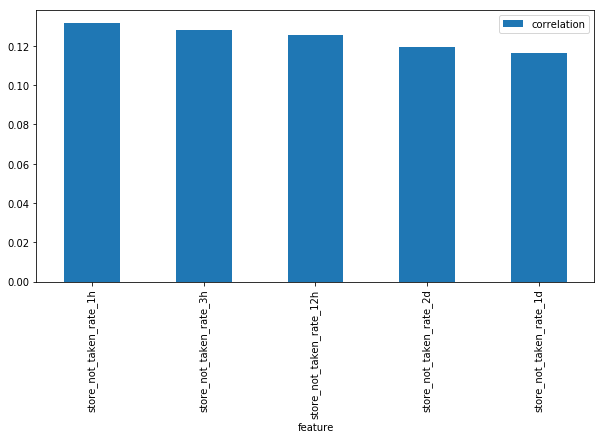

In [36]:
features = [
            'store_not_taken_rate_2d'
            ,'store_not_taken_rate_1d'
            ,'store_not_taken_rate_12h'
            ,'store_not_taken_rate_3h'
            ,'store_not_taken_rate_1h'
            ,'taken'
           ]

# Features correlation coefficent to label
fi = pd.DataFrame({'feature': features,
                   'correlation': merged_inner[features].corr()['taken'].abs(),
                  }).sort_values('correlation', ascending = False)

fi[fi.feature!='taken'].head(20).plot.bar(x='feature', y ='correlation', figsize=(10,5))